In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n/project/"
assert FOLDERNAME is not None, "[!] Enter the foldername."
PROJECT_PATH = f"/content/drive/My Drive/{FOLDERNAME}"
sys.path.append(PROJECT_PATH)

# Change working directory
os.chdir(PROJECT_PATH)

# Confirm
print("✅ Current working directory:", os.getcwd())
print("📁 Contents:", os.listdir('.'))

Mounted at /content/drive
✅ Current working directory: /content/drive/My Drive/cs231n/project
📁 Contents: ['.ipynb_checkpoints', '__pycache__', 'data', 'lora_weights.pth', 'lora.py', 'generated.png', 'patch_unet.py', 'dataset.py', 'verify_data.ipynb', 'lora_sd_colab.ipynb', 'augment.py']


# 💡 LoRA Training on Stable Diffusion
This notebook trains custom LoRA adapters on Stable Diffusion using your own image-caption pairs.


In [3]:
!pip install -q diffusers transformers accelerate torchvision safetensors kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.4 MB/s eta 0:00:00


## Data Preparation

In [4]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from dataset import ImageTextDataset

dataset = ImageTextDataset("data")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# sanity check for datasets
print(f"Number of image-caption pairs: {len(dataset)}")

Number of image-caption pairs: 139


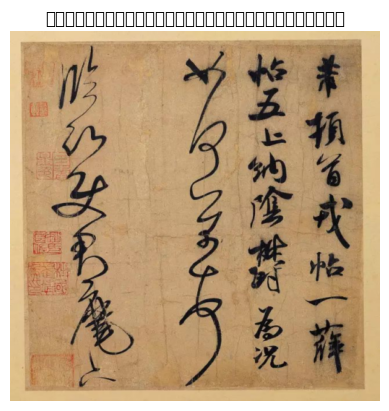

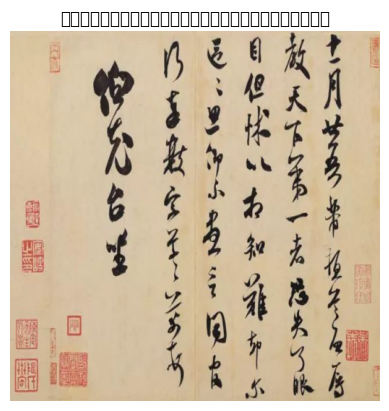

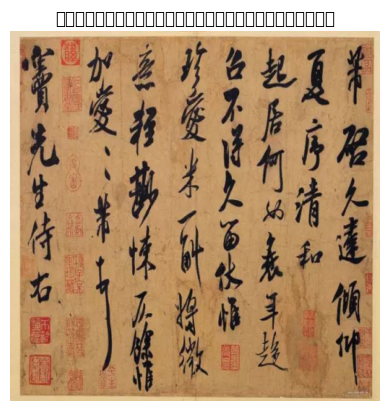

In [5]:
# preview a couple of images.
from matplotlib import pyplot as plt
import warnings
import re

# This regex will match messages containing "Glyph" and "missing from font"
warnings.filterwarnings("ignore", category=UserWarning, message=r"Glyph .* missing from font\(s\) DejaVu Sans\.")

for i in range(min(3, len(dataset))):  # Show up to 3 examples
    image, caption = dataset[i]
    plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Undo normalization
    plt.axis("off")
    plt.title(caption)
    plt.show()


## Training Logic for Lora Finetuning

In [6]:
from lora import LoRALinear
from patch_unet import patch_unet_with_lora, conv_filter

In [10]:
device = "cuda"
from diffusers import StableDiffusionPipeline
import torch.nn as nn


pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32).to(device)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)

# ADD LORA
# patch_unet_with_lora(pipe.unet, r=4, alpha=1.0, dropout=0.0)
patch_unet_with_lora(pipe.unet, r=4, alpha=1.0, dropout=0.0, conv_filter=None)

pipe.unet.to(device)  # Move after patching

# unfreeze lora weights
for module in pipe.unet.modules():
    if "LoRALinear" in str(type(module)):
        for p in module.parameters():
            p.requires_grad = True

optimizer = torch.optim.Adam([p for p in pipe.unet.parameters() if p.requires_grad], lr=1e-4)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# patch_unet_with_lora(
#     pipe.unet,
#     r=4,
#     alpha=1.0,
#     dropout=0.1,
#     enable_linear=False,
#     enable_conv=True,
#     conv_filter=lambda name, mod: "down_blocks" in name and mod.kernel_size == (3, 3)
# )

In [17]:
from augment import augment

# training
for epoch in range(2):
    for i, (images, captions) in enumerate(loader):
        # Keep images in float32
        images = images.to(device)

        images = augment(images)

        text_input = pipe.tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt").to(device)
        text_embeds = pipe.text_encoder(**text_input).last_hidden_state.to(device)  # stays float32

        with torch.no_grad():
            vae_output = pipe.vae.encode(images)
        latents = vae_output.latent_dist.sample().to(device) * 0.18215  # float32

        noise = torch.randn_like(latents).to(device)  # float32 noise
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeds).sample  # float32

        loss = nn.MSELoss()(noise_pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch {epoch} Step {i} Loss: {loss.item():.4f}")

Epoch 0 Step 0 Loss: 0.3767
Epoch 0 Step 1 Loss: 0.0972
Epoch 0 Step 2 Loss: 0.0893
Epoch 0 Step 3 Loss: 0.0063
Epoch 0 Step 4 Loss: 0.0885
Epoch 0 Step 5 Loss: 0.0022
Epoch 0 Step 6 Loss: 0.3674
Epoch 0 Step 7 Loss: 0.0026
Epoch 0 Step 8 Loss: 0.3271
Epoch 0 Step 9 Loss: 0.0029
Epoch 0 Step 10 Loss: 0.2099
Epoch 0 Step 11 Loss: 0.0455
Epoch 0 Step 12 Loss: 0.3293
Epoch 0 Step 13 Loss: 0.0053
Epoch 0 Step 14 Loss: 0.1613
Epoch 0 Step 15 Loss: 0.1910
Epoch 0 Step 16 Loss: 0.0940
Epoch 0 Step 17 Loss: 0.2639
Epoch 0 Step 18 Loss: 0.0019
Epoch 0 Step 19 Loss: 0.0048
Epoch 0 Step 20 Loss: 0.4241
Epoch 0 Step 21 Loss: 0.1235
Epoch 0 Step 22 Loss: 0.0661
Epoch 0 Step 23 Loss: 0.1636
Epoch 0 Step 24 Loss: 0.1065
Epoch 0 Step 25 Loss: 0.0078
Epoch 0 Step 26 Loss: 0.0030
Epoch 0 Step 27 Loss: 0.1279
Epoch 0 Step 28 Loss: 0.0205
Epoch 0 Step 29 Loss: 0.3759
Epoch 0 Step 30 Loss: 0.3683
Epoch 0 Step 31 Loss: 0.1197
Epoch 0 Step 32 Loss: 0.0551
Epoch 0 Step 33 Loss: 0.0910
Epoch 0 Step 34 Loss: 0.

In [18]:
# save model parameters


def save_lora_weights(model, path="lora_weights.pth"):
    lora_state_dict = {}
    for name, module in model.named_modules():
        if isinstance(module, (LoRALinear, LoRAConv2d)):
            lora_state_dict[name + ".lora_down.weight"] = module.lora_down.weight
            lora_state_dict[name + ".lora_up.weight"] = module.lora_up.weight
    torch.save(lora_state_dict, "lora_weights.pth")

# torch.save(
#     {k: v.cpu() for k, v in pipe.unet.state_dict().items() if "lora" in k},
#     "lora_weights.pth"
# )

## Generate images with Trained LoRA

In [20]:
def load_lora_weights(model, path="lora_weights.pth"):
    state_dict = torch.load(path)
    for name, module in model.named_modules():
        if isinstance(module, (LoRALinear, LoRAConv2d)):
            down_key = name + ".lora_down.weight"
            up_key = name + ".lora_up.weight"
            if down_key in state_dict:
                module.lora_down.weight.data.copy_(state_dict[down_key])
            if up_key in state_dict:
                module.lora_up.weight.data.copy_(state_dict[up_key])


<ipython-input-21-f6d9c5d1124b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("lora_weights.pth", map_location=device)


  0%|          | 0/30 [00:00<?, ?it/s]

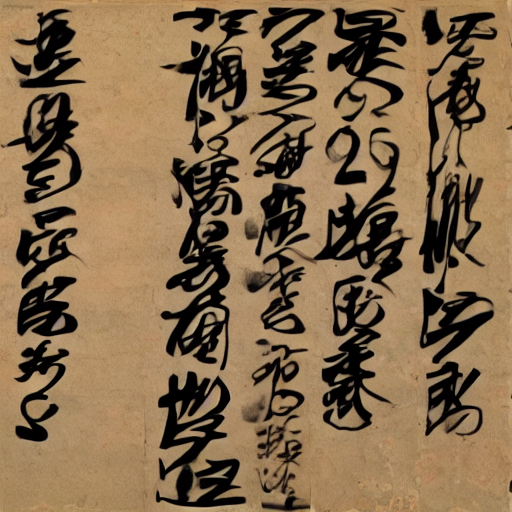

In [21]:
state_dict = torch.load("lora_weights.pth", map_location=device)
patch_unet_with_lora(pipe.unet, r=4, alpha=1.0)
pipe.unet.load_state_dict(state_dict, strict=False)
pipe.unet.eval()

prompt = "米芾 书法"
image = pipe(prompt, num_inference_steps=30).images[0]
image.save("generated.png")
image.show()
display(image)   # shows inline in the notebook
